In [1]:
%load_ext autoreload
%autoreload 2

from synference import SBI_Fitter, generate_constant_R
from unyt import um
from astropy.io import fits
import numpy as np

/cosma/apps/dp276/dc-harv3/venv_simformer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
fitter = SBI_Fitter.init_from_hdf5(
    "Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode",
    "/cosma7/data/dp276/dc-harv3/work/sbi_grids/grid_spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode.hdf5"
)

In [10]:
tab = fits.getdata('/cosma/apps/dp276/dc-harv3/synference/priv/jwst_nirspec_prism_disp.fits')
wavs = tab['WAVELENGTH'] * um
R = tab['R']

In [ ]:
fitter.create_feature_array(flux_units="log10 nJy", crop_wavelength_range=(0.6, 5.0), 
                            resample_wavelengths=wavs, inst_resolution_wavelengths=wavs, 
                            inst_resolution_r=R, theory_r=np.inf, min_flux_value=-10)

2025-10-06 03:37:34,892 | synference | INFO     | Redshift detected. Transforming spectra to observed frame.


Transforming spectra: 100%|██████████| 25000/25000 [08:24<00:00, 49.60it/s]


2025-10-06 03:45:59,311 | synference | INFO     | Spectra feature array created with shape (25000, 1001).
2025-10-06 03:45:59,312 | synference | INFO     | Wavelength Range: 0.500 - 6.000 um
2025-10-06 03:45:59,332 | synference | INFO     | Min flux: -inf log10 nJy
2025-10-06 03:45:59,353 | synference | INFO     | Max flux: 11.161 log10 nJy
2025-10-06 03:45:59,407 | synference | INFO     | Fraction of NaN/INF values in feature array: 4.659%


Redshift: 4.73, log10(M/Msun): 8.59


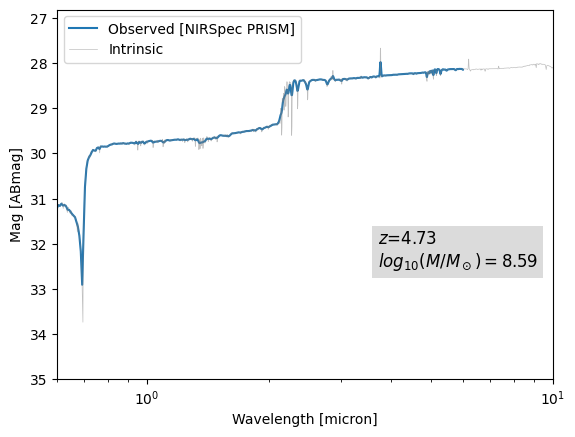

In [107]:
idx = 17

import matplotlib.pyplot as plt
import numpy as np

redshift = fitter.fitted_parameter_array[idx][0]
mass = fitter.fitted_parameter_array[idx][1]
plt.plot(wavs, -2.5*np.log10((1+redshift)*10**fitter.feature_array[idx]) + 31.4, label='Observed [NIRSpec PRISM]')
plt.gca().invert_yaxis()

print(f"Redshift: {redshift:.2f}, log10(M/Msun): {mass:.2f}")
plt.text(3.7, 32.5, f"$z$={redshift:.2f}\n$log_{{10}}(M/M_\\odot)={mass:.2f}$", fontsize=12, color='black', bbox=dict(facecolor='lightgrey', alpha=0.8, edgecolor='none'))
# Show Lyman break
'''plt.axvline(0.1216 * (1 + redshift), color='k', linestyle='--', label='Lyman break')
plt.axvline(0.0912 * (1 + redshift), color='k', linestyle=':', label='Lyman limit')
# Show Hb, Ha
plt.axvline(0.4861 * (1 + redshift), color='r', linestyle='--', label='Hβ')
plt.axvline(0.6563 * (1 + redshift), color='r', linestyle=':', label='Hα')
# Show OIII, OII
plt.axvline(0.5007 * (1 + redshift), color='g', linestyle='--', label='[OIII]')
plt.axvline(0.3727 * (1 + redshift), color='g', linestyle=':', label='[OII]')'''

# normal_spec
ax = plt.gca()
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())
orig = -2.5 * np.log10(fitter.raw_observation_grid[:, idx]) + 31.4
plt.plot(fitter.raw_observation_names*(1 + redshift), orig, color='gray', alpha=0.5, linewidth=0.5, label='Intrinsic')
plt.xlabel("Wavelength [micron]")
plt.ylabel("Mag [ABmag]")
plt.legend()
plt.ylim(35, None)
plt.xlim(0.6, 10)
plt.xscale('log')

In [2]:
run_model = SBI_Fitter.load_saved_model('/cosma/apps/dp276/dc-harv3/synference/models/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode')

2025-10-06 03:34:30,772 | synference | INFO     | Loaded model from /cosma/apps/dp276/dc-harv3/synference/models/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode_20251006_002624_posterior.pkl.
2025-10-06 03:34:30,773 | synference | INFO     | Device: cpu
Posterior p(θ|x) of type EnsemblePosterior. 
2025-10-06 03:34:37,925 | synference | INFO     | Loaded model from /cosma/apps/dp276/dc-harv3/synference/models/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode/Spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode_20251006_002624_posterior.pkl.
2025-10-06 03:34:37,927 | synference | INFO     | Device: cpu
Posterior p(θ|x) of type EnsemblePosterior. 


In [104]:
fitter.feature_array[idx].min()

-8.706377029418945

In [105]:
samples = run_model.sample_posterior(
    X_test=fitter.feature_array[idx],
    num_samples=100,
)

Single sample inference.


In [ ]:
run_model.recreate_simulator_from_grid();

params: {'tau_v': 'tau_v', 'fesc_ly_alpha': 0.0, 'dust_curve': <synthesizer.emission_models.transformers.dust_attenuation.Calzetti2000 object at 0x14e6c5415880>, 'dust_emission': <synthesizer.emission_models.dust.emission.Greybody object at 0x14e6c5363680>}
2025-10-06 03:35:26,859 | synference | ERROR    | Error evaluating transform function for tau_v: illegal target for annotation (<string>, line 1)
2025-10-06 03:35:26,863 | synference | INFO     | Simulator recreated from grid at /cosma7/data/dp276/dc-harv3/work/sbi_grids/grid_spectra_BPASS_Chab_Continuity_SFH_0.01_z_14_logN_4.4_Calzetti_v4_multinode.hdf5.


PhotometrySimulator(<class 'synthesizer.parametric.sf_hist.Continuity'>,
                                        <class 'synthesizer.parametric.metal_dist.DeltaConstant'>,
                                        +------------------------------------------------------------------------------------------------------------------------------------+
|                                                                GRID                                                                |
+-----------------------------+------------------------------------------------------------------------------------------------------+
| Attribute                   | Value                                                                                                |
+-----------------------------+------------------------------------------------------------------------------------------------------+
| grid_dir                    | '/cosma7/data/dp276/dc-harv3/work/grids'                                         

In [106]:
sim = run_model.simulator

sim.param_transforms['Av'] = ('tau_v', lambda Av: Av / 1.086)
sim.output_type = ['fnu', 'photo_fnu']
sim.out_flux_unit = 'nJy'

recovered_sed = []

from tqdm import trange

for i in trange(samples.shape[0]):
    input = {run_model.fitted_parameter_names[j]: samples[i, j] for j in range(len(run_model.fitted_parameter_names))}
    out = sim(input)
    fnu = out['fnu']
    wav = out['fnu_wav']
    recovered_sed.append(fnu)

recovered_sed = np.array(recovered_sed)

recovered_16, recovered_50, recovered_84 = np.percentile(recovered_sed, [16, 50, 84], axis=0)

from synference.utils import transform_spectrum


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


Redshift: 4.73, log10(M/Msun): 8.59


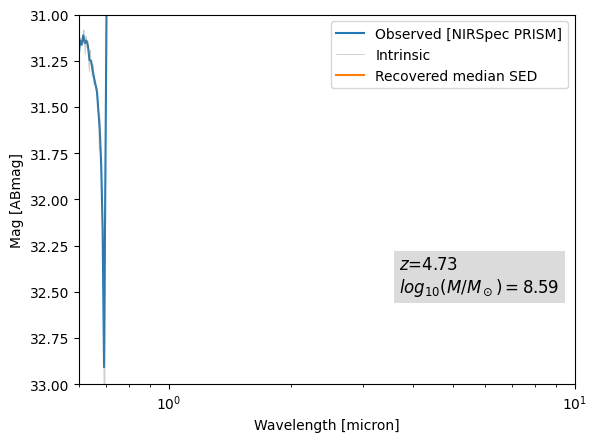

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

redshift = fitter.fitted_parameter_array[idx][0]
mass = fitter.fitted_parameter_array[idx][1]
plt.plot(wavs, -2.5*np.log10((1+redshift)*10**fitter.feature_array[idx]) + 31.4, label='Observed [NIRSpec PRISM]')
plt.gca().invert_yaxis()

print(f"Redshift: {redshift:.2f}, log10(M/Msun): {mass:.2f}")
plt.text(3.7, 32.5, f"$z$={redshift:.2f}\n$log_{{10}}(M/M_\\odot)={mass:.2f}$", fontsize=12, color='black', bbox=dict(facecolor='lightgrey', alpha=0.8, edgecolor='none'))
# Show Lyman break
'''plt.axvline(0.1216 * (1 + redshift), color='k', linestyle='--', label='Lyman break')
plt.axvline(0.0912 * (1 + redshift), color='k', linestyle=':', label='Lyman limit')
# Show Hb, Ha
plt.axvline(0.4861 * (1 + redshift), color='r', linestyle='--', label='Hβ')
plt.axvline(0.6563 * (1 + redshift), color='r', linestyle=':', label='Hα')
# Show OIII, OII
plt.axvline(0.5007 * (1 + redshift), color='g', linestyle='--', label='[OIII]')
plt.axvline(0.3727 * (1 + redshift), color='g', linestyle=':', label='[OII]')'''

# normal_spec
ax = plt.gca()
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())
orig = -2.5 * np.log10(fitter.raw_observation_grid[:, idx]) + 31.4
plt.plot(fitter.raw_observation_names*(1 + redshift), orig, color='gray', alpha=0.5, linewidth=0.5, label='Intrinsic')
plt.xlabel("Wavelength [micron]")
plt.ylabel("Mag [ABmag]")
plt.legend()

plt.xlim(0.6, 10)
plt.xscale('log')

#transformed_16 = transform_spectrum(theory_wave=wav.to('um').value, theory_flux=recovered_16, z=redshift, observed_wave=wavs.to('um').value, resolution_curve_wave=wavs.to('um').value, resolution_curve_r=R)
_, transformed_50 = transform_spectrum(theory_wave=wav.to('um').value/(1 + redshift), theory_flux=recovered_50, z=redshift, observed_wave=wavs.to('um').value, resolution_curve_wave=wavs.to('um').value, resolution_curve_r=R)
#transformed_84 = transform_spectrum(theory_wave=wav.to('um').value, theory_flux=recovered_84, z=redshift, observed_wave=wavs.to('um').value, resolution_curve_wave=wavs.to('um').value, resolution_curve_r=R)

#plt.fill_between(wavs.to('um').value, -2.5*np.log10((1+redshift)*transformed_16) + 31.4, -2.5*np.log10((1+redshift)*transformed_84) + 31.4, color='C1', alpha=0.3, label='68% credible interval')
plt.plot(wavs.to('um').value, -2.5*np.log10((1+redshift)*transformed_50) + 40, color='C1', label='Recovered median SED')
plt.legend()

Redshift: 4.73, log10(M/Msun): 8.59


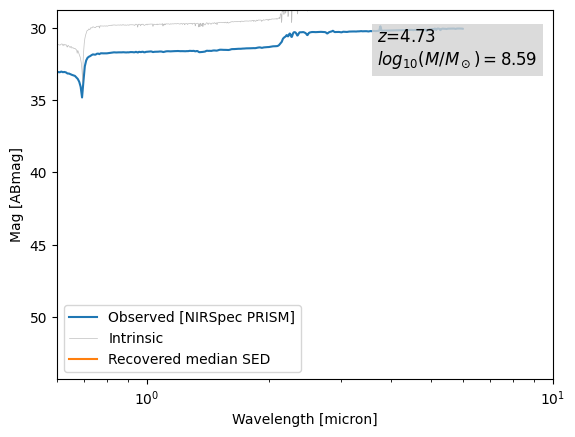

In [109]:
plt.plot(wavs, -2.5*np.log10(10**fitter.feature_array[idx]) + 31.4, label='Observed [NIRSpec PRISM]')
plt.gca().invert_yaxis()

print(f"Redshift: {redshift:.2f}, log10(M/Msun): {mass:.2f}")
plt.text(3.7, 32.5, f"$z$={redshift:.2f}\n$log_{{10}}(M/M_\\odot)={mass:.2f}$", fontsize=12, color='black', bbox=dict(facecolor='lightgrey', alpha=0.8, edgecolor='none'))
# normal_spec
ax = plt.gca()
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())
orig = -2.5 * np.log10(fitter.raw_observation_grid[:, idx]) + 31.4
plt.plot(fitter.raw_observation_names*(1 + redshift), orig, color='gray', alpha=0.5, linewidth=0.5, label='Intrinsic')
plt.xlabel("Wavelength [micron]")
plt.ylabel("Mag [ABmag]")
plt.xlim(0.6, 10)
plt.xscale('log')


#plt.fill_between(wavs.to('um').value, -2.5*np.log10((1+redshift)*transformed_16) + 31.4, -2.5*np.log10((1+redshift)*transformed_84) + 31.4, color='C1', alpha=0.3, label='68% credible interval')
plt.plot(wavs.to('um').value, -2.5*np.log10(transformed_50), color='C1', label='Recovered median SED')
plt.legend()

In [80]:
np.log10(1+redshift)

0.8541532681699735

(0.6, 10.0)

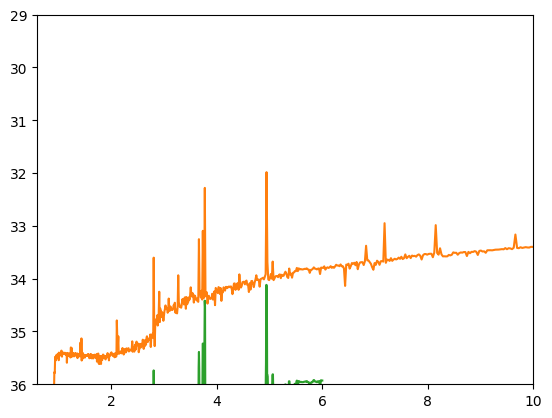

In [66]:
plt.plot(wav.to('um').value, -2.5*np.log10((1+redshift)*recovered_50) + 31.4, color='C1', label='Recovered median SED')
plt.plot(wavs.to('um').value,  -2.5*np.log10((1+redshift)*transformed_50) + 31.4, color='C2', label='Recovered median SED (resampled)')

plt.ylim(36, 29)
plt.xlim(0.6, 10)

AttributeError: module 'matplotlib.pyplot' has no attribute 'x'

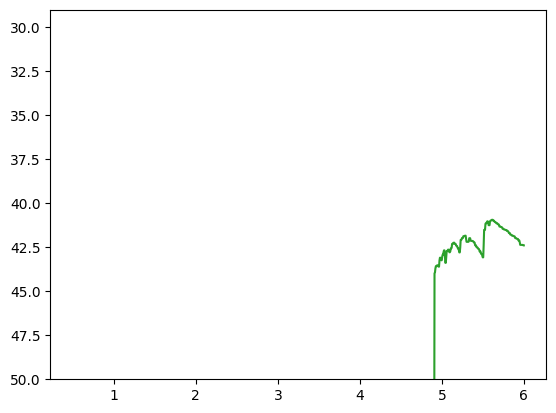

In [ ]:
plt.plot(wavs.to('um').value,  -2.5*np.log10((1+redshift)*transformed_50) + 31.4, color='C2', label='Recovered median SED (resampled)')
plt.ylim(50, 29)
